In [1]:
# ==========================================
# MuJoCo 완벽 설치 코드 (v3: 라이브러리 경로 시스템 등록 추가)
# ==========================================

# 1. 시스템 패키지 및 렌더링 도구 설치
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf libglew-dev
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# 2. [오류 해결 1] libglewosmesa.so 심볼릭 링크 생성
!ln -sf /usr/lib/x86_64-linux-gnu/libGLEW.so /usr/lib/x86_64-linux-gnu/libglewosmesa.so

# 3. MuJoCo 2.1.0 다운로드 및 압축 해제
import os
if not os.path.exists('/root/.mujoco'):
    os.makedirs('/root/.mujoco')

!wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz
!tar -xzf mujoco210-linux-x86_64.tar.gz -C /root/.mujoco/
!rm mujoco210-linux-x86_64.tar.gz

# 4. [오류 해결 2 - 핵심] 시스템 링커(ldconfig)에 경로 강제 등록
# 파이썬 os.environ 만으로는 부족할 때가 있어 시스템 설정파일을 직접 만듭니다.
!echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco.conf
!ldconfig  # 설정 반영

# 5. 환경 변수 설정 (Python 내부용)
os.environ['MUJOCO_PY_MUJOCO_PATH'] = '/root/.mujoco/mujoco210'
os.environ['LD_LIBRARY_PATH'] = '/root/.mujoco/mujoco210/bin:' + os.environ.get('LD_LIBRARY_PATH', '')
os.environ['LD_PRELOAD'] = '/usr/lib/x86_64-linux-gnu/libGLEW.so'

# 6. GitHub 소스코드 클론
if not os.path.exists('deep_rl_algorithm'):
    !git clone https://github.com/LeeJeongWoon-Workout/deep_rl_algorithm.git

# 7. Python 라이브러리 설치
!pip install "cython<3"
!pip install mujoco-py==2.1.2.14
!pip install gym==0.23.1
!pip install imageio==2.9.0
!pip install colabgymrender

print("==========================================")
print("설치 및 경로 등록 완료. 이제 import 에러가 사라질 것입니다.")
print("==========================================")

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,491 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu 

In [2]:
import os
import gym
import time
import argparse
import datetime
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from os.path import join
import deep_rl_algorithm
import mujoco_py
from colabgymrender.recorder import Recorder
import matplotlib.pyplot as plt
!cp -r deep_rl_algorithm/agents agents

# Configurations
parser = argparse.ArgumentParser(description='RL algorithms with PyTorch in MuJoCo environments')
parser.add_argument('--env', type=str, default='HalfCheetah-v2',
                    help='choose an environment between Hopper-v2, HalfCheetah-v2, Ant-v2 and Humanoid-v2')
parser.add_argument('--algo', type=str, default='sac',
                    help='select an algorithm among ddpg, td3, sac')
parser.add_argument('--phase', type=str, default='train',
                    help='choose between training phase and testing phase')
parser.add_argument('--render', action='store_true', default=False,
                    help='if you want to render, set this to True')
parser.add_argument('--load', type=str, default=None,
                    help='copy & paste the saved model name, and load it')
parser.add_argument('--seed', type=int, default=0,
                    help='seed for random number generators')
parser.add_argument('--iterations', type=int, default=100,
                    help='iterations to run and train agent')
parser.add_argument('--steps_per_iter', type=int, default=5000,
                    help='steps of interaction for the agent and the environment in each epoch')
parser.add_argument('--max_step', type=int, default=1000,
                    help='max episode step')
parser.add_argument('--tensorboard', action='store_true', default=True)
parser.add_argument('--gpu_index', type=int, default=0)
args = parser.parse_args(args=[])
device = torch.device('cuda', index=args.gpu_index) if torch.cuda.is_available() else torch.device('cpu')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.dat

Compiling /usr/local/lib/python3.12/dist-packages/mujoco_py/cymj.pyx because it depends on /usr/local/lib/python3.12/dist-packages/mujoco_py/pxd/mujoco.pxd.
[1/1] Cythonizing /usr/local/lib/python3.12/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.12/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_312_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-312/usr/local/lib/python3.12/dist-packages/mujoco_py
INFO:root:creating /usr/local/lib/python3.12/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_312_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-312/usr/local/lib/python3.12/dist-packages/mujoco_py/gl
INFO:root:x86_64-linux-gnu-gcc -fno-strict-overflow -Wsign-compare -DNDEBUG -g -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.12/dist-packages/mujoco_py -I/root/.mujoco/mujoco210/include -I/usr/local/lib/python3.12/dist-packages/numpy/_core/include -I/usr/include/python3.12 -c /usr/local/lib/python3.12/dist-packages/mujoco_py/cymj.c -o /usr/local/lib/python3.12/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_312_linuxcpuextensionbuilder/t

In [ ]:
def main():
    """Main."""

    if args.algo=='ddpg':
      from agents.ddpg import Agent
    elif args.algo=='sac':
      from agents.sac import Agent
    elif args.algo=='td3':
      from agents.td3 import Agent

    # Initialize environment
    env=gym.make(args.env)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    act_limit = env.action_space.high[0]

    interactions=[]
    rewards=[]

    print('---------------------------------------')
    print('Environment:', args.env)
    print('Algorithm:', args.algo)
    print('State dimension:', obs_dim)
    print('Action dimension:', act_dim)
    print('Action limit:', act_limit)
    print('---------------------------------------')

    # Set a random seed
    env.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    # Create an agent
    if args.algo == 'ddpg' or args.algo == 'td3':
        agent = Agent(env, args, device, obs_dim, act_dim, act_limit,
                      act_noise=0.1,
                      hidden_sizes=(256,256),
                      buffer_size=int(1e6),
                      batch_size=64,
                      policy_lr=3e-4,
                      qf_lr=3e-4)
    elif args.algo == 'sac':
        agent = Agent(env, args, device, obs_dim, act_dim, act_limit,
                      alpha=0.2,                        # In HalfCheetah-v2 and Ant-v2, SAC with 0.2
                      hidden_sizes=(256,256),           # shows the best performance in entropy coefficient
                      buffer_size=int(1e6),             # while, in Humanoid-v2, SAC with 0.05 shows the best performance.
                      batch_size=64,
                      policy_lr=3e-4,
                      qf_lr=3e-4)


    # If we have a saved model, load it
    if args.load is not None:
        pretrained_model_path = os.path.join('./save_model/' + str(args.load))
        pretrained_model = torch.load(pretrained_model_path, map_location=device)
        agent.policy.load_state_dict(pretrained_model)

    # Create a SummaryWriter object by TensorBoard
    if args.tensorboard and args.load is None:
        dir_name = 'runs/' + args.env + '/' \
                           + args.algo \
                           + '_s_' + str(args.seed) \
                           + '_t_' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        writer = SummaryWriter(log_dir=dir_name)

    start_time = time.time()

    total_num_steps = 0
    train_sum_returns = 0.
    train_num_episodes = 0


    # Main loop
    for i in range(args.iterations):
        # Perform the training phase, during which the agent learns
        if args.phase=='test' and args.load is not None:
          directory='./video'
          agent.env=Recorder(agent.env,directory)
          agent.run(args.max_step)
          agent.env.play()
          break


        else:
            train_step_count = 0

            while train_step_count <= args.steps_per_iter:
                agent.eval_mode = False

                # Run one episode

                train_step_length, train_episode_return = agent.run(args.max_step)
                total_num_steps += train_step_length
                train_step_count += train_step_length
                train_sum_returns += train_episode_return
                train_num_episodes += 1

                train_average_return = train_sum_returns / train_num_episodes if train_num_episodes > 0 else 0.0

                # Log experiment result for training steps
                if args.tensorboard and args.load is None:
                    writer.add_scalar('Train/AverageReturns', train_average_return, total_num_steps)
                    writer.add_scalar('Train/EpisodeReturns', train_episode_return, total_num_steps)



            interactions.append(train_num_episodes)
            rewards.append(train_episode_return)

            plt.title("{}".format(args.algo))
            plt.plot(interactions,rewards)
            plt.xlabel('Episodes')
            plt.ylabel('Episode Reward')
            plt.show()
        # Perform the evaluation phase -- no learning
        eval_sum_returns = 0.
        eval_num_episodes = 0
        agent.eval_mode = True # When eval_mode is True, no parameter updating

        for _ in range(10):
            # Run one episode
            eval_step_length, eval_episode_return = agent.run(args.max_step)

            eval_sum_returns += eval_episode_return
            eval_num_episodes += 1

        eval_average_return = eval_sum_returns / eval_num_episodes if eval_num_episodes > 0 else 0.0

        # Log experiment result for evaluation steps
        if args.tensorboard and args.load is None:
            writer.add_scalar('Eval/AverageReturns', eval_average_return, total_num_steps)
            writer.add_scalar('Eval/EpisodeReturns', eval_episode_return, total_num_steps)

        if args.phase == 'train':
            print('---------------------------------------')
            print('Iterations:', i + 1)
            print('Steps:', total_num_steps)
            print('Episodes:', train_num_episodes)
            print('EpisodeReturn:', round(train_episode_return, 2))
            print('AverageReturn:', round(train_average_return, 2))
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')

            # Save the trained model
            if not os.path.exists('./save_model'):
                os.mkdir('./save_model')

            ckpt_path = os.path.join('./save_model/' + args.env + '_' + args.algo \
                                                                + '_s_' + str(args.seed) \
                                                                + '_i_' + str(i + 1) \
                                                                + '_tr_' + str(round(train_episode_return, 2)) \
                                                                + '_er_' + str(round(eval_episode_return, 2)) + '.pt')
            if args.algo=='dqn':
              torch.save(agent.qf.state_dict(),ckpt_path)
            else:
              torch.save(agent.policy.state_dict(), ckpt_path)


  logger.warn(

  deprecation(



---------------------------------------
Environment: HalfCheetah-v2
Algorithm: sac
State dimension: 17
Action dimension: 6
Action limit: 1.0
---------------------------------------


  return datetime.utcnow().replace(tzinfo=utc)

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



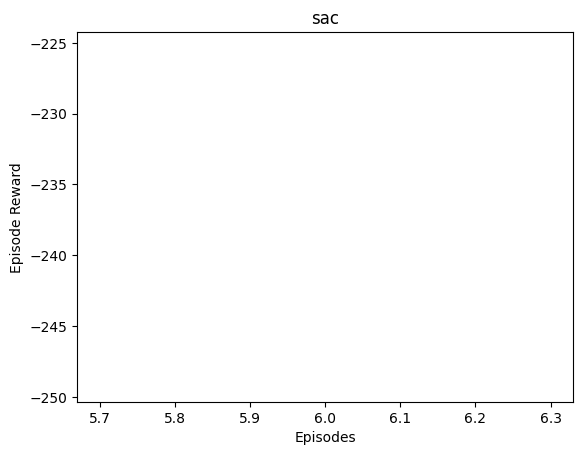

---------------------------------------
Iterations: 1
Steps: 6000
Episodes: 6
EpisodeReturn: -237.29
AverageReturn: -179.13
EvalEpisodes: 10
EvalEpisodeReturn: -30.51
EvalAverageReturn: -24.82
Time: 79
---------------------------------------


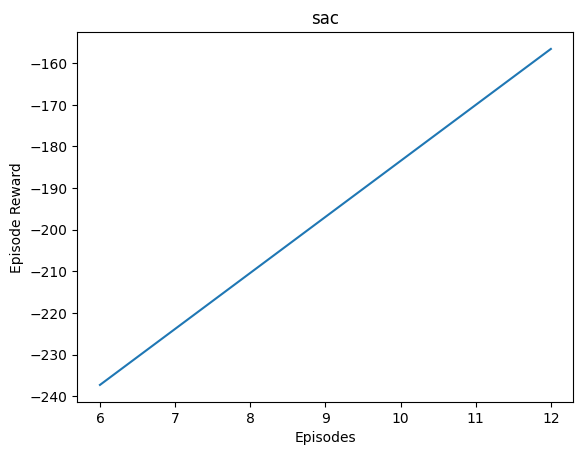

---------------------------------------
Iterations: 2
Steps: 12000
Episodes: 12
EpisodeReturn: -156.56
AverageReturn: -189.79
EvalEpisodes: 10
EvalEpisodeReturn: -62.23
EvalAverageReturn: -64.4
Time: 164
---------------------------------------


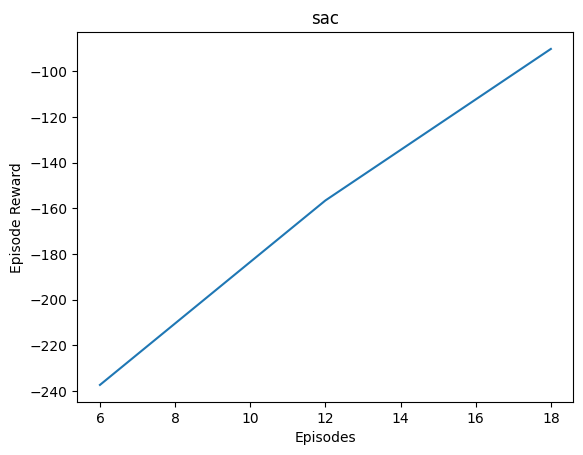

---------------------------------------
Iterations: 3
Steps: 18000
Episodes: 18
EpisodeReturn: -90.24
AverageReturn: -182.99
EvalEpisodes: 10
EvalEpisodeReturn: -101.54
EvalAverageReturn: -96.95
Time: 250
---------------------------------------


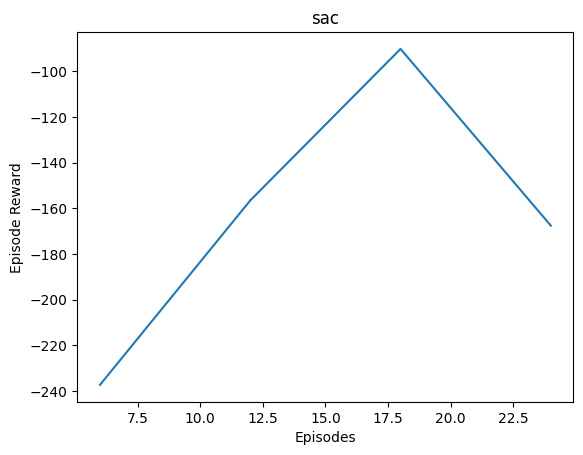

---------------------------------------
Iterations: 4
Steps: 24000
Episodes: 24
EpisodeReturn: -167.59
AverageReturn: -163.67
EvalEpisodes: 10
EvalEpisodeReturn: -5.24
EvalAverageReturn: 5.79
Time: 337
---------------------------------------


In [ ]:
if __name__ == "__main__":
    main()